Currently working in it...... # 2 November 2023
Currently i rectified the error, dl fac as been adjusted and for given range  get the expected params by keeping one and varying other i have get those 6 params at bottom.

In [3]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt
import camb
from camb import model, initialpower
import tensorflow as tf
import os ,sys, platform
import cosmopower as cp
import time
from numba import jit, cuda
from tqdm import tqdm
import multiprocessing

In [113]:
#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

In [148]:
def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Camb_pp(ell,ell_max,parameter,x,lens_accuracy=0): #Function for CAMb
    #camb model pars
    pars = camb.CAMBparams()
    pars.set_cosmology(H0 = par["H0"], ombh2=par["ombh2"], omch2=par["omch2"], mnu=par["mnu"], omk=par["omk"], tau=par["tau"])
    pars.InitPower.set_params(As=par["As"], ns=par["ns"], r=par["r"])
    pars.set_for_lmax(ell_max-1, lens_potential_accuracy=float(lens_accuracy));
    #camb result and power spectra
    camb_results = camb.get_results(pars)
    powers = camb_results.get_cmb_power_spectra(pars, CMB_unit="muK")#,raw_cl=True)
    
    if x == 'TT':
        #CAMB TT
        cambq = powers['lensed_scalar'][:, 0][2:ell_max]
    elif x == 'EE':
        #CAMB EE
        cambq = powers['lensed_scalar'][:, 1][2:ell_max]
    elif x == 'TE':
        #CAMB TE
        cambq = powers['lensed_scalar'][:, 3][2:ell_max]
    else:
        #CAMB TE EE
        cambq = None  
    return cambq 

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    seconds = int(ms/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ms - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'secs ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + 'mins ' + str(s) +'secs ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'mins '+str(s) +'secs ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'mins '+str(s) +'secs ' + str(sm) +' ms' 
    return xi

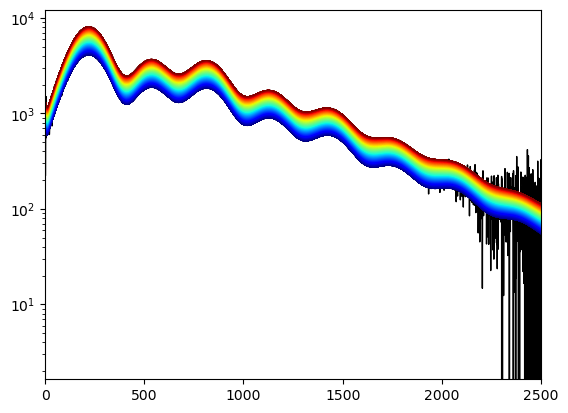

The Best Fitted input Value is 2.0969999999999342 having the chi^2 value is 5970
Total simulations of 15000 Executed in : 89ms 


In [166]:
start_time = time.time() #time calculation

pred_arr = [] #array of prediction [[],[],[]......]
chi2_arr = [] #array of chi2 values[,,,,,...]
input_range = np.arange(1.5,3,0.0001) #range


for val in input_range:    
    #params for cosmopower
    params = {'omega_b': [0.0221],#0.02237],
              'omega_cdm': [0.1205],#1200],#0.47],#0.1200],
              'h': [67.29/100],#67.36,
              'tau_reio': [0.0542],#0.0544],
              'n_s': [0.966],#0.83],#0.945],#0.964
              'ln10^{10}A_s': [np.log( 10**10 *(val*1e-9) )],#3.629
              }
    DATA = 'TT' #'TE' or 'EE' or 'TT'
    if DATA == 'TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    elif DATA == 'TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    elif DATA == 'EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
        pred_arr.append(pred)
        chi2_arr.append(chi)
        
    else:
        print('Check DATA Input')



#plotting all the predicted curves
plt.clf()
color_arr = []
for d in np.linspace(0,255,len(input_range)):
    colr = plt.cm.jet(int(d))
    color_arr.append(colr)
if DATA == 'TT':
    plt.subplot(111,yscale='log')
    plt.xlim(0,2500)
    plt.plot(el,Dl_TT, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el,pred_arr[ii], color =  color_arr[ii], lw=0.2)
elif DATA == 'TE':
    plt.subplot(111)
    plt.xlim(0,1995)
    plt.plot(el_te,Dl_TE, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el_te,pred_arr[ii], color =  color_arr[ii], lw=0.2)
elif DATA == 'EE':
    plt.subplot(111)
    plt.xlim(0,1995)
    plt.plot(el_te,Dl_EE, color= 'black', lw =1)
    for ii in range(len(input_range)):
        plt.plot(el_te,pred_arr[ii], color =  color_arr[ii], lw=0.2)
else :
    print('Check DATA Input')


plt.show()

#finding the input value for the  minimum chi2 value
min_chi2 = np.argmin(chi2_arr) #position of minimum chi2
vals = input_range[min_chi2] #finding Input value of minimum chi2
end_time = time.time() #time calculation
tim = time_hr(end_time - start_time) # finding time for excution
total_values = np.shape(input_range)[0]# Number of values

print('The Best Fitted input Value is', vals,'having the chi^2 value is',min_chi2 )
print( 'Total simulations of',total_values,'Executed in :',tim)

TT params..
'omega_b':0.02210,
'omega_cdm':0.1205 ,
'h':67.29,
'tau_reio':0.0542,
'n_s':0.966,
'ln10^{10}A_s': [np.log( 10**10 *( 2.0969 ) )],